<a href="https://colab.research.google.com/github/mithinKumar/Virtual-Try-on-Closet-using-GAN-SOC/blob/main/Trained_UNet_using_pascalVOCdatset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
import numpy as np
import torchvision.transforms as transforms
from torchvision.datasets import VOCSegmentation
from torch.utils.data import DataLoader,ConcatDataset
import matplotlib.pyplot as plt
import cv2

In [8]:
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])


In [9]:
train_dataset = VOCSegmentation(root='./data', year='2012', image_set='train', download=True, transform=image_transform, target_transform=mask_transform)
val_dataset = VOCSegmentation(root='./data', year='2012', image_set='val', download=True, transform=image_transform, target_transform=mask_transform)


100%|██████████| 1999639040/1999639040 [02:34<00:00, 12934433.88it/s]


Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


In [12]:
# Create DataLoader
# Combine training and validation datasets
combined_dataset = ConcatDataset([train_dataset, val_dataset])
train_loader = DataLoader(combined_dataset, batch_size=4, shuffle=True)


In [13]:
def visualize_batch(images, masks):
    fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(10, 20))
    for i in range(4):
        axs[i, 0].imshow(images[i].permute(1, 2, 0))  # Convert CHW to HWC for matplotlib
        axs[i, 1].imshow(masks[i].squeeze(), cmap='gray')  # Display mask in grayscale
    plt.show()

In [15]:
!pip install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 56.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_6

In [16]:
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch.optim as optim

# Load the pretrained U-Net model with ResNet-34 encoder
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=34  # Number of classes for Cityscapes
)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 380MB/s]


In [17]:
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(device)

cuda


In [22]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [23]:
from tqdm import tqdm
progress_bar = tqdm(total=len(train_dataset), desc='Training', leave = True)

Training:   0%|          | 0/1464 [00:00<?, ?it/s]

In [24]:
# Training loop
num_epochs = 10

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:

        torch.set_printoptions(threshold=10000, edgeitems=1000, linewidth=1000)

        inputs, labels = inputs.to(device), labels.to(device).long()


        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.squeeze(1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        progress_bar.update(1)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')
progress_bar.close()

Training:  50%|████▉     | 730/1464 [01:18<01:30,  8.07it/s]

Epoch 1/10, Loss: 0.19436690913428986


Training: 100%|█████████▉| 1459/1464 [02:27<00:00, 11.97it/s]

Epoch 2/10, Loss: 0.18549380619053324


Training: 2189it [03:36, 11.81it/s]

Epoch 3/10, Loss: 0.1838185852508486


Training: 2918it [04:44, 11.78it/s]

Epoch 4/10, Loss: 0.18156053771779698


Training: 3647it [05:52, 11.78it/s]

Epoch 5/10, Loss: 0.18032964204523624


Training: 4375it [06:59, 11.84it/s]

Epoch 6/10, Loss: 0.18120372869759102


Training: 5105it [08:08, 11.68it/s]

Epoch 7/10, Loss: 0.17949587116924987


Training: 5834it [09:16, 11.70it/s]

Epoch 8/10, Loss: 0.17909264242575493


Training: 6563it [10:24, 11.78it/s]

Epoch 9/10, Loss: 0.17676412741384062


Training: 7290it [11:32, 10.53it/s]

Epoch 10/10, Loss: 0.17615676755583826


In [25]:
def decode_segmap(image, colormap):
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    for l in range(0, len(colormap)):
        idx = image == l
        r[idx] = colormap[l, 0]
        g[idx] = colormap[l, 1]
        b[idx] = colormap[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb

In [51]:
from google.colab import files

# Upload the file
uploaded = files.upload()

# After uploading, specify the filename and load the image
file_name = "2008_000038.jpg"
test_img_path = file_name

test_img = Image.open(test_img_path).convert("RGB")
test_img = transform(test_img).unsqueeze(0).to(device)

with torch.no_grad():
    output = model(test_img)
output = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()



Saving 2008_000038.jpg to 2008_000038 (1).jpg


In [52]:
def create_cityscapes_label_colormap():
    colormap = np.zeros((256, 3), dtype=np.uint8)
    colormap[0] = [128, 64, 128]    # road
    colormap[1] = [244, 35, 232]    # sidewalk
    colormap[2] = [70, 70, 70]      # building
    colormap[3] = [102, 102, 156]   # wall
    colormap[4] = [190, 153, 153]   # fence
    colormap[5] = [153, 153, 153]   # pole
    colormap[6] = [250, 170, 30]    # traffic light
    colormap[7] = [220, 220, 0]     # traffic sign
    colormap[8] = [107, 142, 35]    # vegetation
    colormap[9] = [152, 251, 152]   # terrain
    colormap[10] = [70, 130, 180]   # sky
    colormap[11] = [220, 20, 60]    # person
    colormap[12] = [255, 0, 0]      # rider
    colormap[13] = [0, 0, 142]      # car
    colormap[14] = [0, 0, 70]       # truck
    colormap[15] = [0, 60, 100]     # bus
    colormap[16] = [0, 80, 100]     # train
    colormap[17] = [0, 0, 230]      # motorcycle
    colormap[18] = [119, 11, 32]    # bicycle
    colormap[19] = [0, 0, 0]        # void
    colormap[20] = [105, 105, 105]  # dynamic
    colormap[21] = [169, 169, 169]  # static
    colormap[22] = [192, 192, 192]  # guard rail
    colormap[23] = [128, 128, 0]    # bridge
    colormap[24] = [255, 255, 255]  # tunnel
    colormap[25] = [0, 128, 0]      # parking
    colormap[26] = [0, 128, 128]    # rail track
    colormap[27] = [128, 0, 128]    # guard rail
    colormap[28] = [128, 128, 64]   # fence
    colormap[29] = [128, 128, 192]  # wall
    colormap[30] = [192, 128, 64]   # building
    colormap[31] = [192, 128, 128]  # pole
    colormap[32] = [192, 192, 128]  # traffic sign
    colormap[33] = [255, 192, 128]  # traffic light
    colormap[34] = [128, 255, 255]  # sky
    return colormap

In [53]:
colormap = create_cityscapes_label_colormap()
segmentation_map = decode_segmap(output, colormap)

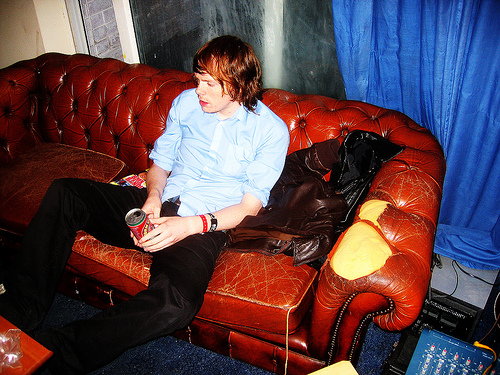

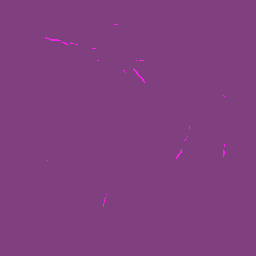

In [54]:
import cv2
from google.colab.patches import cv2_imshow

# Load and display the original image
img = cv2.imread(test_img_path)
cv2_imshow(img)

# Display the segmentation map (assuming 'segmentation_map' is properly defined)
cv2_imshow(cv2.cvtColor(segmentation_map, cv2.COLOR_RGB2BGR))
cv2.waitKey(0)
cv2.destroyAllWindows()


In [46]:
print(len(combined_dataset))

2913


In [ ]:
# Save the model weights
model_save_path = 'unet_cityscapes.pth'
torch.save(model.state_dict(), model_save_path)


In [ ]:
# Load the model weights
model_load_path = 'unet_cityscapes.pth'
model.load_state_dict(torch.load(model_load_path, map_location=device))
model.eval()  # Set the model to evaluation mode

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track